#  Прогноз оттока клиентов оператора связи

Небходимо разработать модель прогнозирования оттока клиентов для оператора связи. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Нам доступны персональные данные о некоторых клиентах, информация об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.



## Предобработка данных

In [1]:
%%capture
!pip install catboost
!pip install phik
!pip install scikit-plot

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scikitplot as skplt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from catboost import CatBoostClassifier
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier


Ознакомимся с данными.

Выведем таблицу df_contract.

In [ ]:
df_contract = pd.read_csv('/datasets/contract_new.csv')

df_contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [ ]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [ ]:
df_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


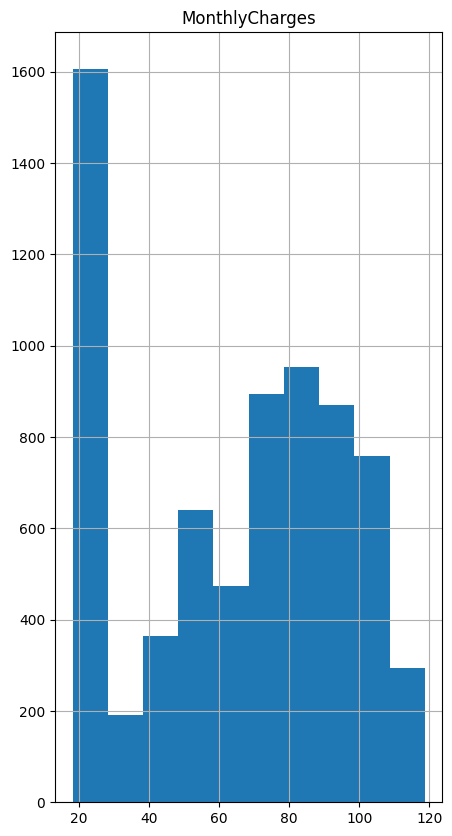

In [ ]:
df_contract.hist(figsize=(5, 10));

Датасет df_contract содержит информацию о договорах, заключенных с клиентами:
1. BeginDate - дата начала пользования услугами;
2. EndDate - дата окончания пользования услугами;
3. Type - тип оплаты: ежемесячный, годовой и т.д.;
4. PaperlessBilling - безналичный расчет;
5. PaymentMethod - способ оплаты;
6. MonthlyCharges - ежемесячные траты на услуги;
7. TotalCharges - всего потрачено денег на услуги.

Всего в этой таблице 7043 строк. Практически все данные имеют тип object, за исключением столбца MonthlyCharges, тип данных в котором float64.

Необходимо перевести данные, содержащиеся в столбце TotalCharges, в float64.

In [ ]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract['TotalCharges'].dtype

dtype('float64')

In [ ]:
df_contract.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

После изменения типа данных в столбце TotalCharges образовалось 11 пропусков. Посмотрим, в каких строках присутствуют пропуски.

In [ ]:
mask = df_contract.isnull().any(axis=1)

rows_with_nulls = df_contract[mask]
rows_with_nulls

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Пропуски присутствуют в данных о клиентах, договор с которыми был заключен 1 февраля 2020 г. Заполним пропуски соответствующими данными из столбца MonthlyCharges.

In [ ]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(df_contract['MonthlyCharges'])
df_contract['TotalCharges'].isna().sum()

0

Выведем таблицу df_personal.

In [ ]:
df_personal = pd.read_csv('/datasets/personal_new.csv')

df_personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [ ]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [ ]:
df_personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


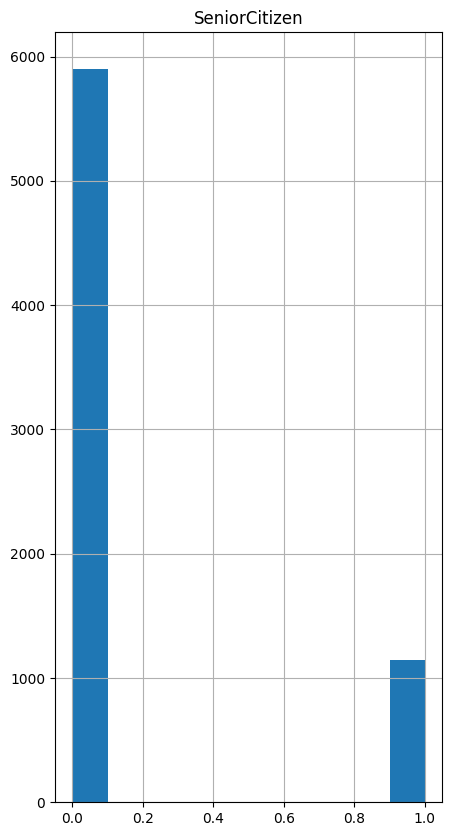

In [ ]:
df_personal.hist(figsize=(5, 10));

Датасет df_personal содержит персональные данные клиента:
1. gender - пол;
2. SeniorCitizen - наличие пенсионного статуса по возрасту;
3. Partner - наличие супруга(и);
4. Dependents - наличие иждивенцев.

Датасет также содержит 7043 строк. Типы данных соответствуют самим данным.

Выведем таблицу df_internet.

In [ ]:
df_internet = pd.read_csv('/datasets/internet_new.csv')

df_internet.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [ ]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [ ]:
df_internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Датасет df_internet содержит информацию об интернет-услугах:
1. InternetService - вэб-сервисы;
2. OnlineSecurity - блокировка небезопасных сайтов;
3. OnlineBackup - облачное хранилище файлов для резервного копирования данных;
4. DeviceProtection - антивирус;
5. TechSupport - выделенная линия технической поддержки;
6. StreamingTV - стриминговое телевидение;
7. StreamingMovies - каталог фильмов.

Всего в таблице 5517 строк. Это связано с тем, что не все клиенты пользуются интернет-услугами.
Все данные имеют тип object. Замена типа не требуется, так как в каждом столбце отражен факт пользования конкретной услугой.

Выведем таблицу df_phone.

In [ ]:
df_phone = pd.read_csv('/datasets/phone_new.csv')

df_phone.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [ ]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [ ]:
df_phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


В данной таблице содержится информация о наличии возможности ведения параллельных линий во время звонка. Количество строк 6361. Это также связано с тем, что не все клиенты пользуются данной услугой. Тип данных нет необходимости изменять.

Объединим таблицы df_contract, df_personal, df_internet и df_phone в одну общую таблицу. Объединять будем по столбцу customerID, общему для всех этих таблиц.

In [ ]:
df_full = pd.merge(df_contract, df_personal, on='customerID', how='left')
df_full = pd.merge(df_full, df_internet, on='customerID', how='left')
df_full = pd.merge(df_full, df_phone, on='customerID', how='left')
df_full.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Сводная таблица df_full состоит из 20 столбцов и 7043 строк.

Проверим наличие пропусков.

In [ ]:
df_full.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

При объединении таблиц df_internet и df_phone образовались пропуски, поскольку в них изначально было меньшее количество строк. Заполним их значением 'No', так как оно указывает на то, что клиент не пользуется данной услугой.

In [ ]:
df_full = df_full.fillna('No')
df_full.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Проверим наличие дубликатов.

In [ ]:
df_full.duplicated().sum()

0

Дубликатов не обнаружено.

Создадим новый стоблец, содержащий целевой признак, где факт ухода клиента будет помечен 1. Если же клиент продолжает пользоваться услугами компании, то в этом случае ему будет присвоена метка 0. Данные возьмем из столбца EndDate.

In [ ]:
df_full['Target'] = df_full['EndDate'].apply(lambda x: 0 if x=='No' else 1)

Создадим новый признак 'Лояльность клиента'. Получим его путем вычитания из даты окончания пользования услугами (EndDate) дату начала (BeginDate). Для этого переведем тип данных этих столбцов в datetime.
В случае, если дата окончания отсутствует, будем вычитать дату начала из даты 01 февраля 2020 г., на которую данные являются актуальными.

In [ ]:
df_full['EndDate'] = df_full['EndDate'].replace('No', '2020-02-01')

In [ ]:
df_full['BeginDate'] = pd.to_datetime(df_full['BeginDate'])
df_full['BeginDate'].dtype

dtype('<M8[ns]')

In [ ]:
df_full['EndDate'] = pd.to_datetime(df_full['EndDate'])
df_full['EndDate'].dtype

dtype('<M8[ns]')

In [ ]:
df_full['Loyalty'] = df_full['EndDate'] - df_full['BeginDate']
df_full['Loyalty']

0        31 days
1      1036 days
2       123 days
3      1371 days
4       153 days
          ...   
7038    730 days
7039   2191 days
7040    337 days
7041    215 days
7042   2010 days
Name: Loyalty, Length: 7043, dtype: timedelta64[ns]

Для удобства изменим тип данных Loyalty с timedelta64 на int.

In [ ]:
df_full['Loyalty'] = df_full['Loyalty'].dt.days.astype(int)
df_full['Loyalty'].dtype

dtype('int64')

Удалим из датасета столбцы BeginDate и EndDate, так как данная информация может привести  к утечке данных.

In [ ]:
df_full = df_full.drop(['BeginDate', 'EndDate'],  axis=1)
df_full.columns

Index(['customerID', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'Target', 'Loyalty'],
      dtype='object')

Удалим столбец customerID, поскольку он не представляет ценности для обучения моделей.

In [ ]:
df_full = df_full.drop(['customerID'],  axis=1)

Проверим корреляцию признаков. Так как у нас смешанный набор данных, воспользуемся библиотекой phik.

In [ ]:
phik_overview = df_full.phik_matrix()
phik_overview

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'Target', 'Loyalty']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,Loyalty
Type,1.000000,0.106860,0.277462,0.388444,0.468471,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.094015,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.203144,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.083398,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335175,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.214832,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.711029,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.226280,0.387727
TotalCharges,0.468471,0.203144,0.335175,0.711029,1.000000,0.000000,0.137707,0.381042,0.082134,0.489674,0.521522,0.622643,0.641455,0.549866,0.642144,0.644671,0.572584,0.304287,0.847414
gender,0.000000,0.000000,0.000000,0.008175,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.137707,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.086159,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381042,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.226688,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.082134,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.046871,0.198729
InternetService,0.505187,0.231438,0.323886,0.919002,0.489674,0.000000,0.160702,0.000000,0.108463,1.000000,0.241421,0.233602,0.232916,0.239663,0.272818,0.272782,0.225383,0.056621,0.060845


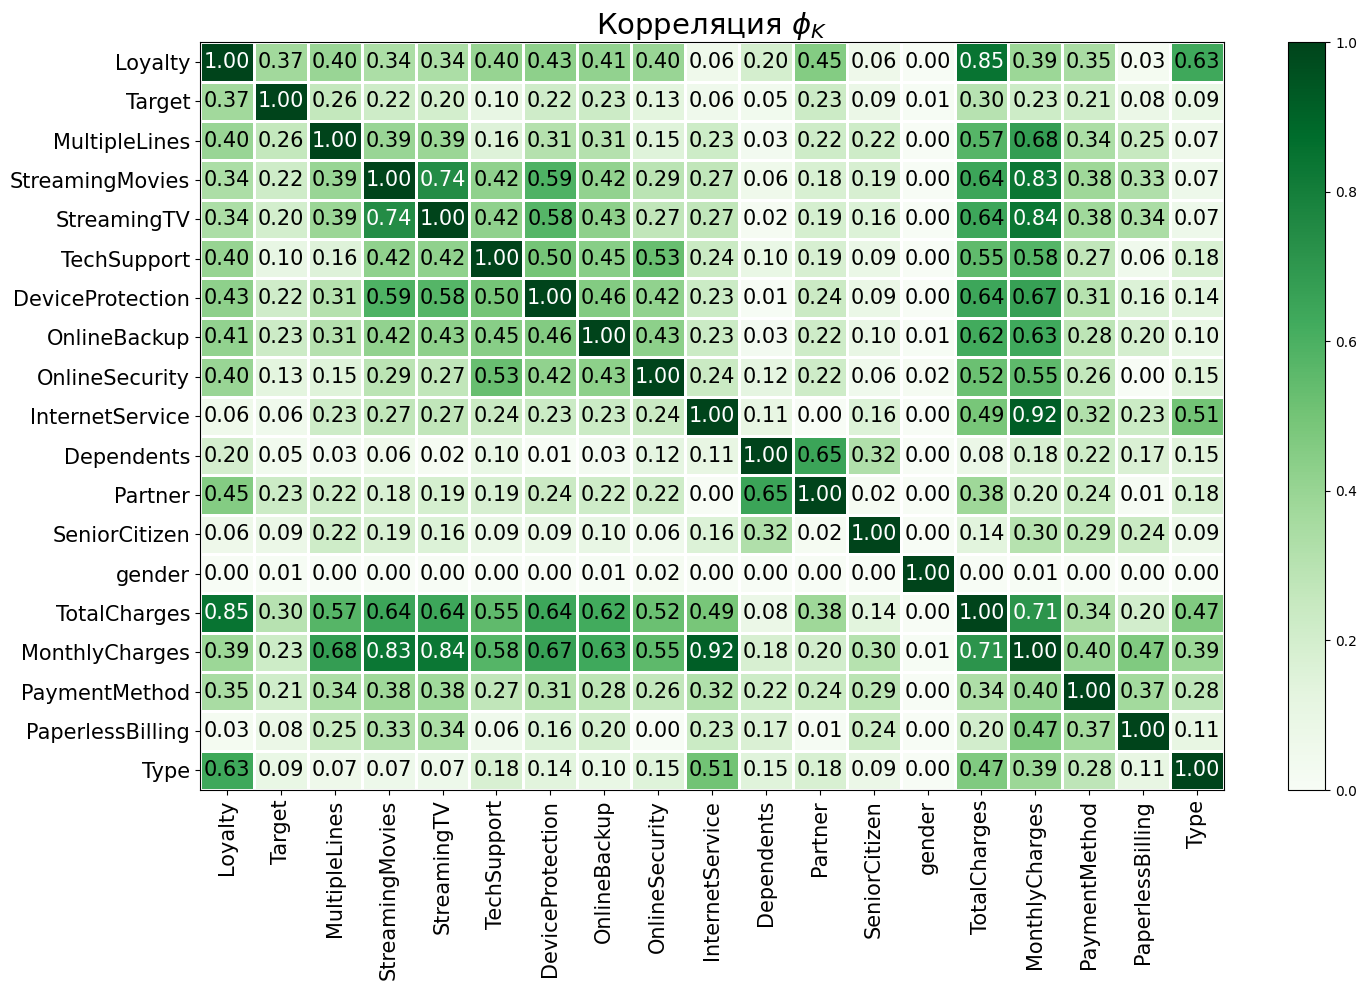

In [ ]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(15, 10))
plt.tight_layout()

Обнаружена высокая корреляция MonthlyCharges с
TotalCharges, Loyalty а также с предоставляемыми услугами. Удалим столбец MonthlyCharges.

In [ ]:
df_full = df_full.drop(['MonthlyCharges'],  axis=1)

**Вывод**
Была выполнена предварительная обработка данных в представленных датасетах, после чего они были объединиены в одну общую таблицу.
Созданы новые признаки:
1. Лояльность клиента, полученная путем вычитания из даты окончания пользования услугами (EndDate) даты начала (BeginDate). После чего столбцы BeginDate и EndDate были удалены, так как данная информация может привести к утечке данных при обучении моделей.
2. Целевой признак. Факт ухода клиента помечен 1; если же клиент продолжает пользоваться услугами компании, то в этом случае ему присвоена метка 0. Данные взяты из столбца EndDate.

После проверки корреляции признаков был удален столбец MonthlyCharges, так как была выявлена высокая корреляция данного признака с TotalCharges, Loyalty и с предоставляемыми услугами.

## Исследовательский анализ данных

Проведем исследовательский анализ данных по лояльным и ушедшим клиентам.

In [ ]:
df_full.describe()

,TotalCharges,SeniorCitizen,Target,Loyalty
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,2115.377573,0.162147,0.156325,898.555729
std,2112.678861,0.368612,0.363189,683.130510
min,19.050000,0.000000,0.000000,0.000000
25%,436.750000,0.000000,0.000000,276.000000
50%,1343.350000,0.000000,0.000000,761.000000
75%,3236.690000,0.000000,0.000000,1461.000000
max,9221.380000,1.000000,1.000000,2314.000000


Посмотрим на соотношение оставшихся и ушедших клиентов.

0    0.843675
1    0.156325
Name: Target, dtype: float64


<Axes: >

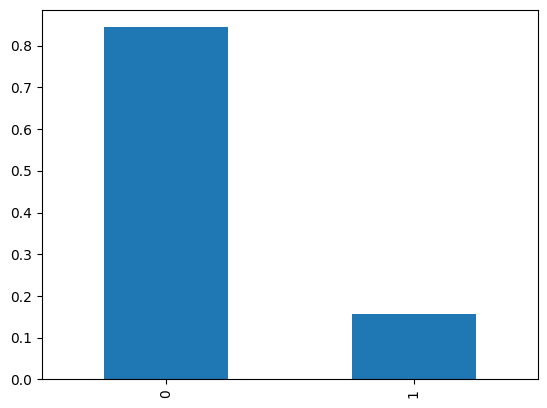

In [ ]:
class_frequency = df_full['Target'].value_counts(normalize = 1)
print(class_frequency)
class_frequency.plot(kind='bar')

Количество оставшихся клиентов значительно превышает количество ушедших клиентов.

Посмотрим на распределение клиентов в зависимости от их пола.

<Axes: xlabel='gender', ylabel='Count'>

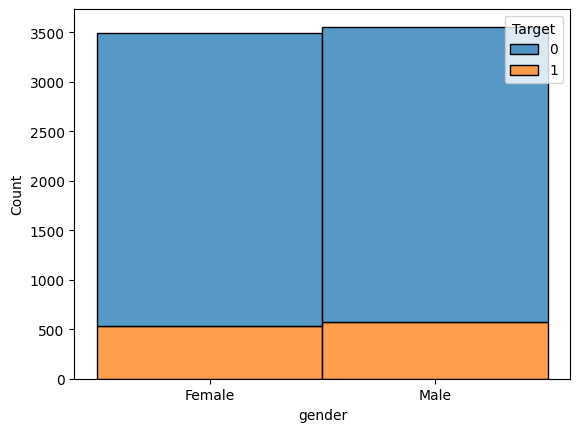

In [ ]:
sns.histplot(df_full, x = 'gender', hue = 'Target', multiple = 'stack')

Клиентов обоих полов в той, и в другой группе практически одинаковое количество. Мужчин чуть больше.

Помотрим на признак SeniorCitizen - наличие пенсионного статуса по возрасту.

<Axes: xlabel='SeniorCitizen', ylabel='Count'>

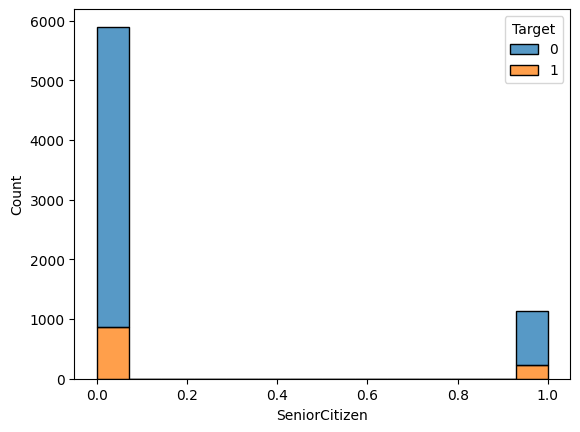

In [ ]:
sns.histplot(df_full, x = 'SeniorCitizen', hue = 'Target', multiple = 'stack')

В обеих группах людей пенсионного возраста значительно меньше, чем людей, не обладающих данным статусом.

Посмотрим на наличие супруга(и).

<Axes: xlabel='Partner', ylabel='Count'>

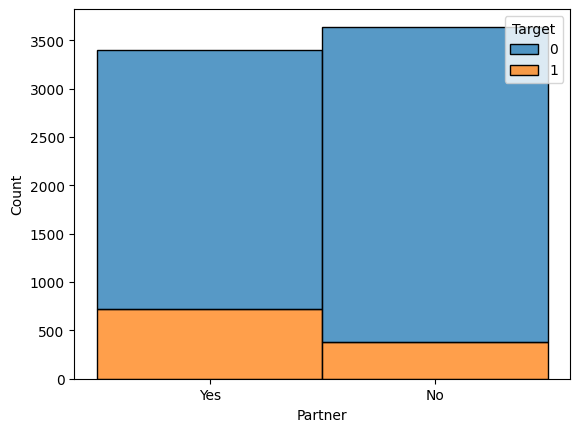

In [ ]:
sns.histplot(df_full, x = 'Partner', hue = 'Target', multiple = 'stack')

В группе ушедших клиентов преобладают люди, состоящие в браке. В группе оставшихся, напротив, люди, не имеющие супруга(у).

Посмотрим на признак Dependents - наличие иждивенцев.

<Axes: xlabel='Dependents', ylabel='Count'>

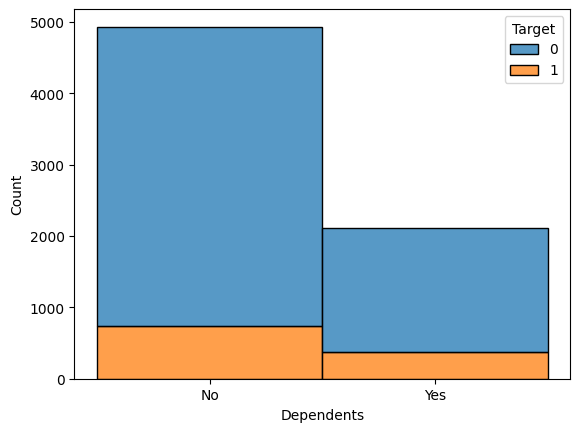

In [ ]:
sns.histplot(df_full, x = 'Dependents', hue = 'Target', multiple = 'stack')

В обеих группах преобладают клиенты, не имеющие иждивенцев.

Посмотрим на признак Type, описывающий тип оплаты.

<Axes: xlabel='Type', ylabel='Count'>

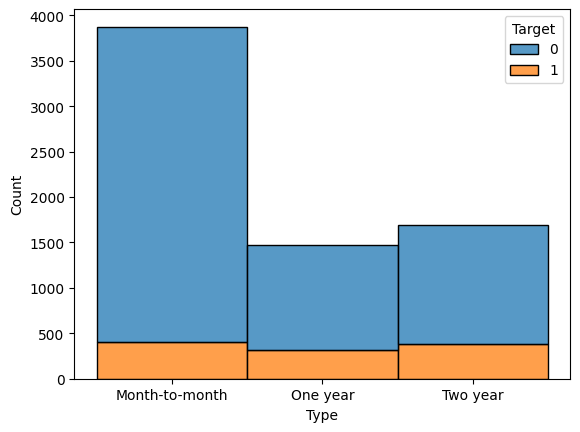

In [ ]:
sns.histplot(df_full, x = 'Type', hue = 'Target', multiple = 'stack')

На графике видно, что ушедшие клиенты пользовались всеми типами оплаты примерно одинаково. Оставшиеся клиенты предпочитают оплачивать услуги, используя тип 'Month-to-month'. Двумя другими типами - 'One year Type' и 'Two year' - пользуются значительно реже.

Посмотрим на признак PaperlessBilling, указывающий на факт безналичного расчета.

<Axes: xlabel='PaperlessBilling', ylabel='Count'>

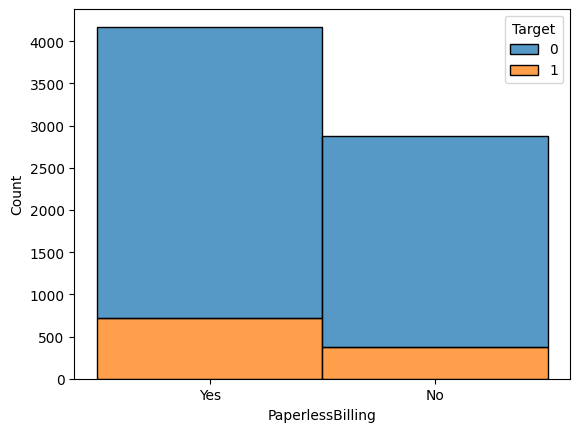

In [ ]:
sns.histplot(df_full, x = 'PaperlessBilling', hue = 'Target', multiple = 'stack')

И те, и другие клиенты предпочитают безналичный расчет.

Посмотрим на признак PaymentMethod, описывающий способ оплаты.

<Axes: xlabel='PaymentMethod', ylabel='Count'>

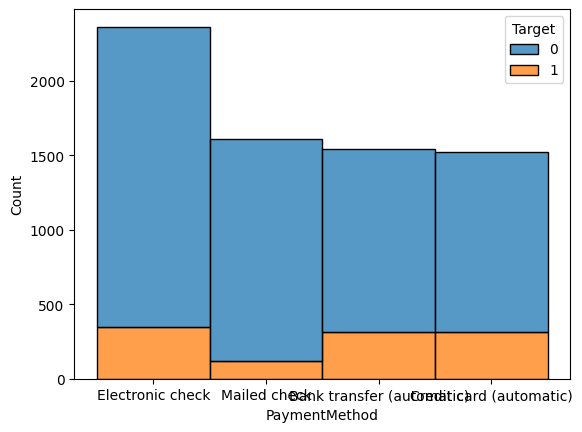

In [ ]:
sns.histplot(df_full, x = 'PaymentMethod', hue = 'Target', multiple = 'stack')

Оставшиеся клиенты предпочитают Electronic check. Ушедшие пользуются всеми способами одинаково часто, единственное исключение - Mailed check. Его используют реже всего.

Посмотрим на признак TotalCharges - общую сумму, потраченную на оплату услуг.

<Axes: xlabel='TotalCharges', ylabel='Count'>

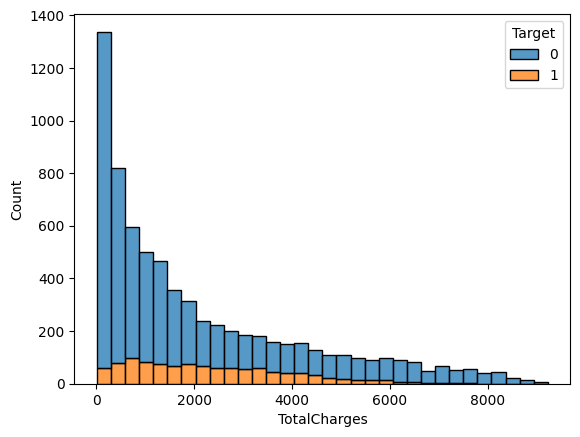

In [ ]:
sns.histplot(df_full, x = 'TotalCharges', hue = 'Target', multiple = 'stack')

С увеличением суммы количество оставшихся клиентов убывает. Количество ушедших клиентов с ростом общей суммы сначала плавно увеличивается, но потом начинает постепенно сокращаться.

Посмотрим на признак InternetService.

<Axes: xlabel='InternetService', ylabel='Count'>

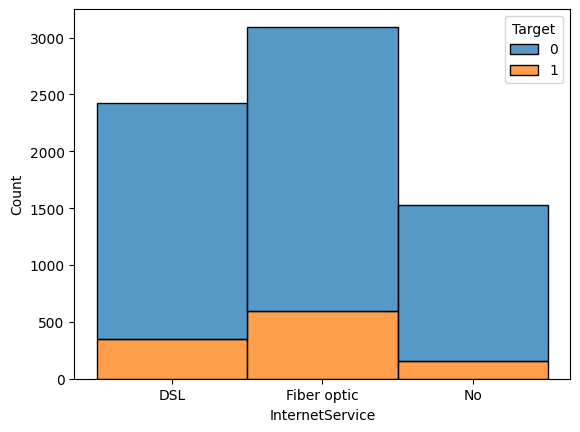

In [ ]:
sns.histplot(df_full, x = 'InternetService', hue = 'Target', multiple = 'stack')

Клиенты в обеих группах пользуются вэб-сервисами в одинаковом соотношении.

Посмотрим на признак OnlineSecurity.

<Axes: xlabel='OnlineSecurity', ylabel='Count'>

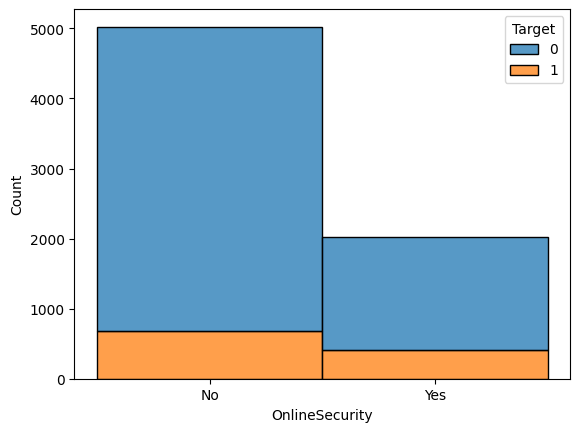

In [ ]:
sns.histplot(df_full, x = 'OnlineSecurity', hue = 'Target', multiple = 'stack')

Большинство и тех, и других клиентов не пользуются услугой блокировки небезопасных сайтов.

Посмотрим на признак OnlineBackup.

<Axes: xlabel='OnlineBackup', ylabel='Count'>

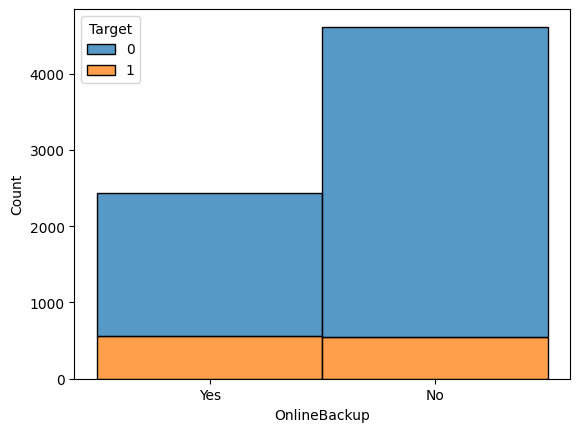

In [ ]:
sns.histplot(df_full, x = 'OnlineBackup', hue = 'Target', multiple = 'stack')

Клиенты, продолжающие пользоваться услугами компании, в большинстве своем не используют облачное хранилище. Доли ушедших клиентов разделились одинаково.

Посмотрим на признак DeviceProtection.

<Axes: xlabel='DeviceProtection', ylabel='Count'>

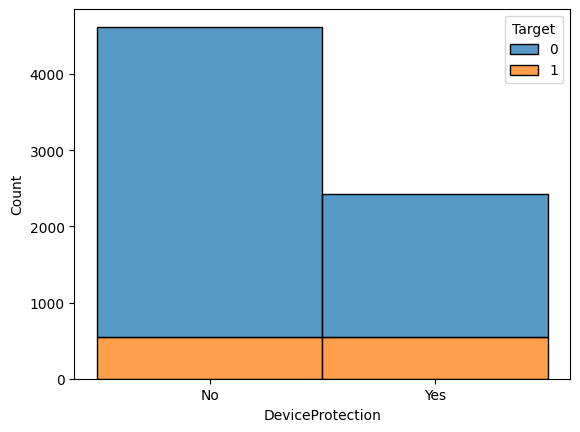

In [ ]:
sns.histplot(df_full, x = 'DeviceProtection', hue = 'Target', multiple = 'stack')

Также большинство оставшихся клиентов не пользуется антивирусом. Ушедшие же клиенты снова разделились одинаково.

Посмотрим на признак TechSupport.

<Axes: xlabel='TechSupport', ylabel='Count'>

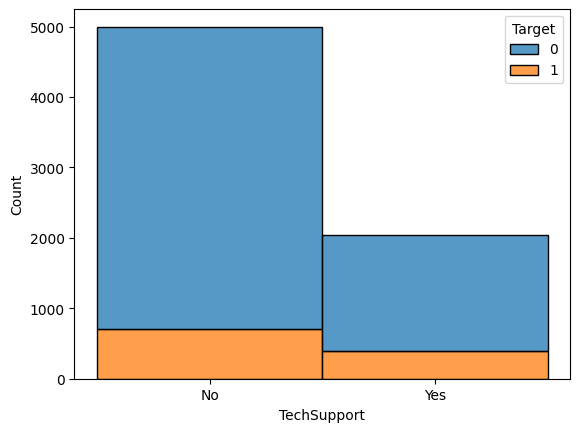

In [ ]:
sns.histplot(df_full, x = 'TechSupport', hue = 'Target', multiple = 'stack')

Клиенты в обеих группах предпочитают не использовать выделенную линию технической поддержки.

Посмотрим на признак StreamingTV .

<Axes: xlabel='StreamingTV', ylabel='Count'>

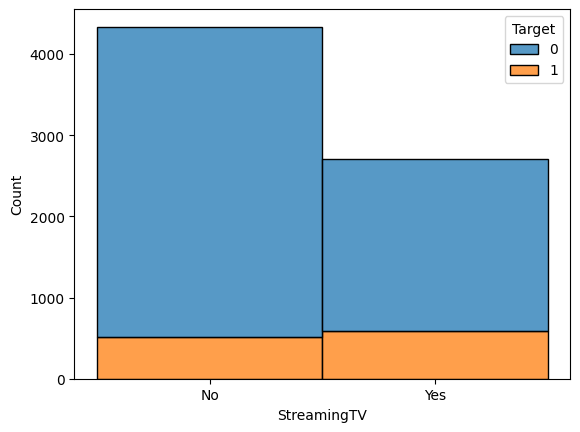

In [ ]:
sns.histplot(df_full, x = 'StreamingTV', hue = 'Target', multiple = 'stack')

Ушедшие клиенты пользовались стриминговым телевидением более активно.

Посмотрим на признак StreamingMovies.

<Axes: xlabel='StreamingMovies', ylabel='Count'>

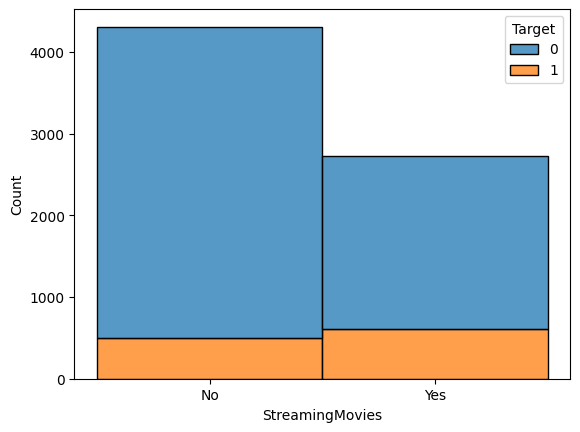

In [ ]:
sns.histplot(df_full, x = 'StreamingMovies', hue = 'Target', multiple = 'stack')

Также ушедшие клиенты более активно использовали каталог фильмов.

Посмотрим на признак MultipleLines.

<Axes: xlabel='MultipleLines', ylabel='Count'>

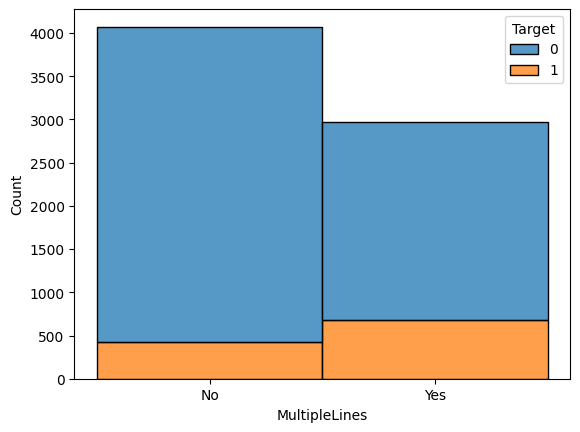

In [ ]:
sns.histplot(df_full, x = 'MultipleLines', hue = 'Target', multiple = 'stack')

Ушедшие клиенты чаще пользовались возможностью ведения параллельных линий во время звонка. Оставшиеся же предпочитали не пользоваться.

**Вывод**
На основе проведенного исследовательского анализа данных можно сделать вывод, что среди ушедших клиентов преобладает доля тех, кто пользовался дополнительными услугами. В то время как среди оставшихся клиентов большинство предпочитает не использовать данные услуги.

## Обучение моделей

Разобъем данные на обучающую и тестовую выборки. Поскольку для подбора оптимальных гиперпараметров мы будем использовать кросс-валидацию, валидационная выборка нам не понадобится.

In [ ]:
features = df_full.drop('Target', axis=1)
target = df_full['Target']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=220523, stratify=target)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(5282, 17) (1761, 17) (5282,) (1761,)


Преобразуем категориальные признаки в численные при помощи техники OneHotEncoder. Перед этим отдельно сохраним признаки для CatBoost, так как данная модель умеет работать с категориальными переменными - в кодировании нет необходимости.

In [ ]:
# признаки для модели CatBoost
features_train_cat = features_train.copy()
features_test_cat = features_test.copy()

In [ ]:
categorical_features = features.select_dtypes(include=['object']).columns

In [ ]:
ohe_features = categorical_features
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
features_train = features_train.drop(ohe_features, axis=1)
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)

features_train.head()

,TotalCharges,SeniorCitizen,Loyalty,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
5450,169.30,0,62,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
6056,4165.04,0,1767,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
4612,2941.25,0,1979,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
43,5030.55,0,1918,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
6860,1994.18,0,577,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


Обучим модель логистической регрессии. Перед этим для данной модели масштабируем признаки при помощи StandardScaler. Для этого создадим Pipeline. Подберем параметры при помощи GridSearchCV.

In [ ]:
%%time
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=220523, class_weight='balanced'))

param_grid = {'logisticregression__C': [0.1, 1, 10],
              'logisticregression__penalty': ['l1', 'l2']}
model_lr = GridSearchCV(pipe, param_grid=param_grid, cv=5,
                  scoring={'ROC_AUC_score': 'roc_auc', 'Accuracy': 'accuracy'}, refit='ROC_AUC_score')
model_lr.fit(features_train, target_train)
print("ROC-AUC:", model_lr.best_score_)

ROC-AUC: 0.7654714220446316
CPU times: user 844 ms, sys: 638 ms, total: 1.48 s
Wall time: 1.7 s


Построим модель дерева принятия решений. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
%%time
classifier_dt = DecisionTreeClassifier(random_state=220523, class_weight='balanced')

param_grid = {'max_depth': [depth for depth in range(1, 50)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
model_dt = RandomizedSearchCV(classifier_dt, param_distributions=param_grid, cv=5,
                   scoring={'ROC_AUC_score': 'roc_auc', 'Accuracy': 'accuracy'}, refit='ROC_AUC_score')

model_dt.fit(features_train, target_train)
print("ROC-AUC:", model_dt.best_score_)

ROC-AUC: 0.7954348762169172
CPU times: user 1.54 s, sys: 59.2 ms, total: 1.6 s
Wall time: 2.4 s


Построим модель случайный лес. Подберем параметры при помощи RandomizedSearchCV.

In [ ]:
%%time
classifier_rf = RandomForestClassifier(random_state=220523, class_weight='balanced')

parameters = {'n_estimators': [est for est in range(1, 50)],
           'max_depth': [depth for depth in range(1, 20)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
model_rf = RandomizedSearchCV(classifier_rf, param_distributions=parameters, cv=5,
                              scoring={'ROC_AUC_score': 'roc_auc', 'Accuracy': 'accuracy'}, refit='ROC_AUC_score')
model_rf.fit(features_train, target_train)
print("ROC-AUC:", model_rf.best_score_)

ROC-AUC: 0.819055013487217
CPU times: user 7.79 s, sys: 43.7 ms, total: 7.83 s
Wall time: 11.8 s


Обучим модель CatBoost.

In [ ]:
%%time
cat = CatBoostClassifier(random_state=220523, verbose=False)
cat_features = categorical_features
parameters_cat = {
                   'learning_rate': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
                   'depth': [1, 2, 4, 6, 10, 20],
                   'l2_leaf_reg': [1, 3, 5, 7, 9],
                   'iterations': [300, 500, 600, 700],
                   'cat_features': [list(cat_features)]
}
model_cat = RandomizedSearchCV(cat, param_distributions=parameters_cat, cv=5,
                               scoring={'ROC_AUC_score': 'roc_auc', 'Accuracy': 'accuracy'}, refit='ROC_AUC_score', n_jobs = -1)
model_cat.fit(features_train_cat, target_train)
print("ROC-AUC:", model_cat.best_score_)

ROC-AUC: 0.9293369352728845
CPU times: user 5.89 s, sys: 714 ms, total: 6.61 s
Wall time: 2min 45s


In [ ]:
model_cat.best_params_

{'learning_rate': 0.2,
 'l2_leaf_reg': 1,
 'iterations': 700,
 'depth': 2,
 'cat_features': ['Type',
  'PaperlessBilling',
  'PaymentMethod',
  'gender',
  'Partner',
  'Dependents',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'MultipleLines']}

Построим кривую обучения для визуальной оценки процесса обучения модели CatBoost.

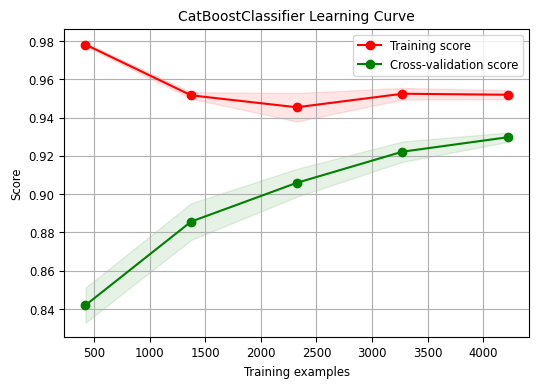

In [ ]:
skplt.estimators.plot_learning_curve(model_cat.best_estimator_, features_train_cat, target_train,
                                     figsize=(6,4), title_fontsize="medium", text_fontsize="small",
                                     title="CatBoostClassifier Learning Curve");

Кривая обучения модели и на обучающем, и на проверочном наборе данных сходится и стабилизируется на высоком уровне точности. Это может указывать на то, что модель хорошо обобщает данные и не переобучена.

**Вывод**    
Были обучены четыре модели: модель логистической регрессии, дерево принятия решений, случайный лес и CatBoost. Лучший результат показал CatBoost. Эту модель мы и будем проверять на тестовой выборке.

## Тестирование модели

Лучший результат показала модель  CatBoost. Проверим ее на тестовой выборке.

In [ ]:
probabilities_test = model_cat.predict_proba(features_test_cat)
probabilities_one_test = probabilities_test[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_test)
roc_auc

0.9351682368775236

Построим ROC-кривую выбранной нами модели. Она показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров.

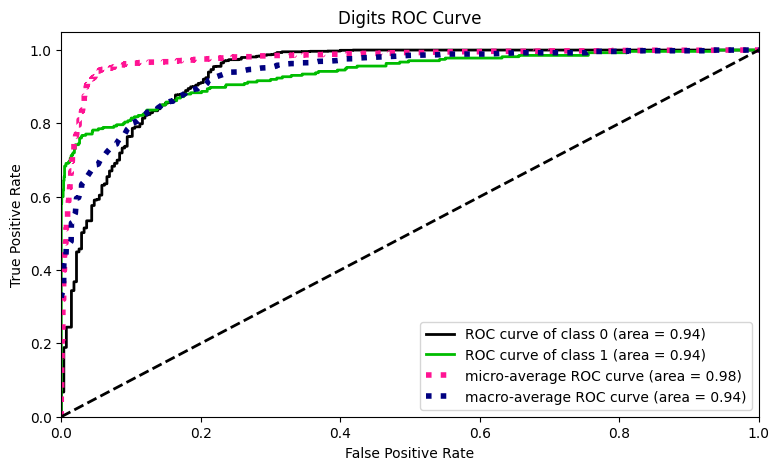

In [ ]:
skplt.metrics.plot_roc_curve(target_test, probabilities_test, title="Digits ROC Curve", figsize=(9,5));

Для идеального классификатора график ROC-кривой проходит через верхний левый угол, где доля истинно положительных случаев составляет 100% или 1,0 (идеальная чувствительность), а доля ложно положительных примеров равна нулю. Поэтому, чем ближе кривая к верхнему левому углу, тем выше предсказательная способность модели. Наоборот, чем меньше изгиб кривой и чем ближе она расположена к диагональной прямой, тем менее эффективна модель. Диагональная линия соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов.
Построенная нами ROC-кривая имеет достаточно большой изгиб и высокое значение AUC-ROC 0.93.

Проверим модель на адекватность при помощи DummyClassifier.

In [ ]:
dummy = DummyClassifier(strategy="stratified")
dummy.fit(features_train, target_train)
proba = dummy.predict_proba(features_test)
roc_auc = roc_auc_score(target_test, proba[:, 1])

print("ROC AUC:", roc_auc)

ROC AUC: 0.5139924140462498


Результат на тестовой выборке выше показателя AUC-ROC, полученного на dummy-модели.

Проведем анализ важности признаков для лучшей модели.

In [ ]:
best_model = model_cat.best_estimator_
feature_importances = best_model.feature_importances_
feature_names = best_model.feature_names_
feature_importances_list = sorted(list(zip(feature_names, feature_importances)), key=lambda x: x[1], reverse=True)
for feature, importance in feature_importances_list:
    print(f"{feature}: {importance}")

Loyalty: 77.37892713505384
TotalCharges: 6.962297095597184
Type: 4.881193425799732
PaymentMethod: 2.2634991644763445
MultipleLines: 2.2040227628439184
Partner: 1.946584458112614
InternetService: 1.1228620309722042
OnlineBackup: 0.7572927872915354
StreamingMovies: 0.588567973792597
DeviceProtection: 0.46349554827392175
StreamingTV: 0.3234733772463798
PaperlessBilling: 0.2499316257182905
OnlineSecurity: 0.2284912714121656
SeniorCitizen: 0.21819118959956255
Dependents: 0.20373091273159522
TechSupport: 0.18586517630864022
gender: 0.021574064769476604


Наиболее важным оказался созданный нами признак Loyalty. Далее с большим отрывом следует TotalCharges. Наименее значимые признаки TechSupport,  OnlineSecurity (что вероятно связано с низким спросом на данные услуги), PaperlessBilling и пол клиентов.

## Отчет по работе

Цель данного проекта заключалась в создании и обучении моделей бинарной классификации для предсказания оттока клиентов. Для проверки качества моделей использовалась метрика roc_auc. Предварительно был составлен план, включающий в себя этапы работы над поставленной задачей. Все этапы были успешно выполнены. В процессе выполнения проекта каких-либо серьезных затрудненений не возникло.

Работа состояла из следующих этапов:    

1. Предварительная обработка данных:     
 1.1. Были изучены все представленные датасеты. Тип данных, содержащихся в столбце TotalCharges, изменен с object на float64. Образовавшиеся пропуски заполнены соответствующими данными из столбца MonthlyCharges, поскольку они присутствовали в данных о клиентах, договор с которыми был заключен 1 февраля 2020 г.     
 1.2. Все таблицы объединены в одну по столбцу customerID, общему для всех этих таблиц. При объединении таблиц df_internet и df_phone образовались пропуски, поскольку в них изначально было меньшее количество строк. Они были заполнены значением 'No', так как оно указывает на то, что клиент не пользуется данной услугой. Дубликатов при проверке не было обнаружено.     
 1.3. Создали новый стоблец, содержащий целевой признак, где факт ухода клиента был помечен 1. Если же клиент продолжает пользоваться услугами компании, то в этом случае ему была присвоена метка 0. Данные взяли из столбца EndDate.    
 1.4. Создали новый признак 'Лояльность клиента' (Loyalty). Данный признак был получен путем вычитания из даты окончания пользования услугами (EndDate) дату начала (BeginDate). Для этого перевели тип данных в этих столбцах в datetime. В том случае, когда дата окончания отсутствовала, вычитали дату начала из даты 01 февраля 2020 г., на которую данные являются актуальными.  Для удобства тип данных Loyalty был изменен с timedelta64 на int.    
 1.5. Столбцы BeginDate и EndDate были удалены из датасета, так как информация, содержащаяся в них, могла привести к утечке данных.     
 1.6. Столбец customerID также был удален, поскольку он не представлял ценности для обучения моделей.     
 1.7. Была проверена корреляция признаков. Для этого воспользовались библиотекой phik, так как представленный набор данных является смешанным.  Была обнаружена высокая корреляция MonthlyCharges с TotalCharges, Loyalty, а также с предоставляемыми услугами. Столбец MonthlyCharges был удален.   


2. Исследовательский анализ данных по лояльным и ушедшим клиентам:    
 2.1. Построенные графики продемонстрировали, что среди ушедших клиентов преобладает доля тех, кто пользовался дополнительными услугами. В то время как среди оставшихся клиентов большинство предпочитает не использовать данные услуги.    


3. Обучение моделей:    
 3.1. Данные разбиты на обучающую и тестовую выборки (размер тестовой выборки: test_size = 0.25; RANDOM_STATE = 220523). Поскольку для подбора оптимальных гиперпараметров мы использовали кросс-валидацию, валидационная выборка нам не понадобилась.    
 3.2. Категориальные признаки преобразованы в численные при помощи техники OneHotEncoder, числовые признаки масштабированы при помощи StandardScaler. Для обучения использовались признаки:    
 - Loyalty (был сгенерирован)
 - TotalCharges
 - Type
 - PaymentMethod
 - InternetService
 - MultipleLine
 - Partner
 - SeniorCitizen
 - StreamingMovies
 - StreamingTV
 - OnlineBackup
 - DeviceProtection
 - Dependents
 - OnlineSecurity
 - PaperlessBilling
 - gender
 - TechSupport

 3.3. Были обучены четыре модели: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и CatBoost. Для подбора гиперпараметров использовались GridSearchCV и RandomizedSearchCV. Лучший результат показала CatBoost.

param_distributions для CatBoost

{'learning_rate': [0.1, 0.2, 0.5, 0.7, 0.9, 1],
'depth': [1, 2, 4, 6, 10, 20],
'l2_leaf_reg': [1, 3, 5, 7, 9],
'iterations': [300, 500, 600, 700],
'cat_features': [list(cat_features)]}

model_cat.best_params_

{'learning_rate': 0.9,
 'l2_leaf_reg': 1,
 'iterations': 700,
 'depth': 2}


4. Тестирование модели CatBoost на тестовой выборке.

ROC-AUC на тестовой выборке 0.94


5. Анализ важности признаков для лучшей модели:     
 5.1. Анализ показал, что наиболее важным является созданный нами признак Loyalty. Далее с большим отрывом следует TotalCharges. Наименее значимые признаки TechSupport, OnlineSecurity (что вероятно связано с низким спросом на данные услуги), PaperlessBilling и пол клиентов.